**STAGE 1:** Download images from [Dataset_timelapse_photos/Fugle_107_to_Hansbukta/2016](https://geodata.igf.edu.pl/Dataset_timelapse_photos/Fugle_107_to_Hansbukta/2016/)

In [2]:
# =========================================
# STAGE 2: Iterate through all months safely
# Environment: Google Colab
# =========================================

import os
from datetime import datetime

BASE_DIR = "/content/drive/MyDrive/DATASETS/Hansbreen_2016"

# Get month folders (e.g. 201604, 201605, ...)
months = sorted([d for d in os.listdir(BASE_DIR) if d.startswith("2016")])

print("Found months:", months)

total_images = 0

for month in months:
    folder = os.path.join(BASE_DIR, month)
    images = [f for f in os.listdir(folder) if f.lower().endswith(".jpg")]
    print(f"Month {month}: {len(images)} images")
    total_images += len(images)

print("Total images across all months:", total_images)


Found months: ['201604', '201605', '201606', '201607', '201608', '201609', '201610', '201611', '201612']
Month 201604: 850 images
Month 201605: 1049 images
Month 201606: 525 images
Month 201607: 2651 images
Month 201608: 3144 images
Month 201609: 2378 images
Month 201610: 972 images
Month 201611: 149 images
Month 201612: 50 images
Total images across all months: 11768


In [3]:
# =====================================================
# STAGE 3: Calving Event Detection using Image Differencing
# =====================================================

import os
import cv2
import numpy as np
import pandas as pd
from datetime import datetime

# -------- CONFIG --------
BASE_DIR = "/content/drive/MyDrive/DATASETS/Hansbreen_2016"
OUTPUT_CSV = "/content/drive/MyDrive/DATASETS/calving_events.csv"

DIFF_THRESHOLD = 25       # Pixel intensity threshold
MIN_EVENT_AREA = 500     # Minimum area (pixels) to be considered calving

# -------- HELPER FUNCTIONS --------
def preprocess(img):
    """Convert to grayscale and smooth image"""
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    return blur

def extract_timestamp(filename):
    """Extract timestamp from filename"""
    try:
        return datetime.strptime(filename[:13], "%Y%m%d_%H%M")
    except:
        return None

# -------- MAIN PIPELINE --------
events = []

months = sorted([d for d in os.listdir(BASE_DIR) if d.startswith("2016")])

for month in months:
    print(f"Processing month: {month}")
    folder = os.path.join(BASE_DIR, month)

    files = sorted([f for f in os.listdir(folder) if f.lower().endswith(".jpg")])

    prev_img = None
    prev_time = None

    for f in files:
        path = os.path.join(folder, f)
        img = cv2.imread(path)

        if img is None:
            continue

        img_p = preprocess(img)
        timestamp = extract_timestamp(f)

        if prev_img is not None:
            # Image differencing
            diff = cv2.absdiff(img_p, prev_img)

            # Thresholding
            _, binary = cv2.threshold(diff, DIFF_THRESHOLD, 255, cv2.THRESH_BINARY)

            # Noise removal
            kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
            clean = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)

            # Connected components
            num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(clean)

            for i in range(1, num_labels):
                area = stats[i, cv2.CC_STAT_AREA]
                if area >= MIN_EVENT_AREA:
                    cx, cy = centroids[i]
                    events.append({
                        "month": month,
                        "timestamp": prev_time,
                        "event_area_px": area,
                        "centroid_x": cx,
                        "centroid_y": cy
                    })

        prev_img = img_p
        prev_time = timestamp

print("Total detected events:", len(events))

# -------- SAVE RESULTS --------
df = pd.DataFrame(events)
df.to_csv(OUTPUT_CSV, index=False)

print("Saved results to:", OUTPUT_CSV)


Processing month: 201604
Processing month: 201605
Processing month: 201606
Processing month: 201607
Processing month: 201608
Processing month: 201609
Processing month: 201610
Processing month: 201611
Processing month: 201612
Total detected events: 582852
Saved results to: /content/drive/MyDrive/DATASETS/calving_events.csv


Install + load data + quick  check




In [36]:
# =====================================================
# STAGE 4: Dashboard (Plotly Dash) - Setup & Data Load

# =====================================================

!pip -q install dash==2.17.1 jupyter-dash==0.4.2 plotly pandas

import pandas as pd

CSV_PATH = "/content/drive/MyDrive/DATASETS/calving_events.csv"

df = pd.read_csv(CSV_PATH)

# Convert timestamp to datetime
df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")
df = df.dropna(subset=["timestamp"])

# Basic derived columns
df["date"] = df["timestamp"].dt.date

print("Rows:", len(df))
print("Months:", sorted(df["month"].unique().tolist()))
print("Date range:", df["timestamp"].min(), "→", df["timestamp"].max())
df.head()


Rows: 582852
Months: [201604, 201605, 201606, 201607, 201608, 201609, 201610, 201611, 201612]
Date range: 2016-04-14 11:15:00 → 2016-12-26 12:02:00


,month,timestamp,event_area_px,centroid_x,centroid_y,date
0,201604,2016-04-14 11:15:00,3366,4234.096851,312.000891,2016-04-14
1,201604,2016-04-14 11:15:00,46533,3825.426493,481.878151,2016-04-14
2,201604,2016-04-14 11:15:00,1340,4149.726866,366.429851,2016-04-14
3,201604,2016-04-14 11:15:00,1592,4238.576005,362.292714,2016-04-14
4,201604,2016-04-14 11:15:00,20030,2841.060160,462.609785,2016-04-14


Run the interactive dashboard in Colab

In [5]:
# =====================================================
# STAGE 4: Dashboard (Plotly Dash) - App
# =====================================================

from jupyter_dash import JupyterDash
from dash import dcc, html, Input, Output
import plotly.express as px

# ---- Build options for dropdown ----
month_options = [{"label": "All months", "value": "ALL"}] + \
                [{"label": m, "value": m} for m in sorted(df["month"].unique())]

app = JupyterDash(__name__)

app.layout = html.Div([
    html.H2("Glacier Calving Dashboard (Hansbreen 2016)", style={"marginBottom": "6px"}),
    html.P("Event-based image differencing results (calving_events.csv).", style={"marginTop": "0px"}),

    # ---- Controls ----
    html.Div([
        html.Div([
            html.Label("Select month"),
            dcc.Dropdown(
                id="month_dropdown",
                options=month_options,
                value="ALL",
                clearable=False
            )
        ], style={"width": "220px", "display": "inline-block", "marginRight": "20px"}),

        html.Div([
            html.Label("Min event area (pixels)"),
            dcc.Slider(
                id="min_area_slider",
                min=0,
                max=int(df["event_area_px"].quantile(0.99)),  # avoid extreme outliers for slider max
                step=50,
                value=500,
                tooltip={"placement": "bottom", "always_visible": True}
            )
        ], style={"width": "520px", "display": "inline-block", "verticalAlign": "top"})
    ], style={"marginBottom": "20px"}),

    # ---- KPI cards ----
    html.Div(id="kpi_row", style={"display": "flex", "gap": "12px", "marginBottom": "18px"}),

    # ---- Charts ----
    html.Div([
        html.Div([dcc.Graph(id="events_over_time")], style={"flex": "1"}),
    ], style={"display": "flex", "gap": "12px"}),

    html.Div([
        html.Div([dcc.Graph(id="area_hist")], style={"flex": "1"}),
        html.Div([dcc.Graph(id="spatial_plot")], style={"flex": "1"}),
    ], style={"display": "flex", "gap": "12px"})
], style={"maxWidth": "1200px", "margin": "0 auto", "fontFamily": "Arial"})


def make_kpi_card(title, value):
    return html.Div([
        html.Div(title, style={"fontSize": "12px", "color": "#666"}),
        html.Div(value, style={"fontSize": "22px", "fontWeight": "bold"})
    ], style={
        "padding": "12px",
        "border": "1px solid #ddd",
        "borderRadius": "10px",
        "background": "white",
        "minWidth": "180px"
    })


@app.callback(
    Output("kpi_row", "children"),
    Output("events_over_time", "figure"),
    Output("area_hist", "figure"),
    Output("spatial_plot", "figure"),
    Input("month_dropdown", "value"),
    Input("min_area_slider", "value")
)
def update_dashboard(selected_month, min_area):
    # Filter data
    dff = df.copy()
    if selected_month != "ALL":
        dff = dff[dff["month"] == selected_month]
    dff = dff[dff["event_area_px"] >= min_area]

    # KPIs
    total_events = len(dff)
    date_min = dff["timestamp"].min()
    date_max = dff["timestamp"].max()
    mean_area = dff["event_area_px"].mean() if total_events > 0 else 0

    kpis = [
        make_kpi_card("Total events", f"{total_events:,}"),
        make_kpi_card("Date range", f"{date_min.date() if pd.notna(date_min) else '-'} → {date_max.date() if pd.notna(date_max) else '-'}"),
        make_kpi_card("Mean event area (px)", f"{mean_area:,.1f}")
    ]

    # Events per day
    if total_events > 0:
        daily = dff.groupby("date").size().reset_index(name="events")
        fig_time = px.line(daily, x="date", y="events", markers=True, title="Calving events per day")
    else:
        fig_time = px.line(title="Calving events per day")

    # Event size distribution
    fig_hist = px.histogram(
        dff, x="event_area_px", nbins=40,
        title="Event size distribution (area in pixels)"
    )

    # Spatial plot of event centroids
    # Note: Image coordinates usually have (0,0) at top-left, so we reverse y-axis for intuitive display
    fig_spatial = px.scatter(
        dff, x="centroid_x", y="centroid_y",
        title="Event locations (centroids)",
        opacity=0.6
    )
    fig_spatial.update_yaxes(autorange="reversed")

    # Clean layout
    for fig in [fig_time, fig_hist, fig_spatial]:
        fig.update_layout(margin=dict(l=30, r=20, t=50, b=30))

    return kpis, fig_time, fig_hist, fig_spatial


# Run inside notebook
app.run_server(mode="inline", height=780)


/usr/local/lib/python3.12/dist-packages/dash/dash.py:556: UserWarning:

JupyterDash is deprecated, use Dash instead.
See https://dash.plotly.com/dash-in-jupyter for more details.



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [27]:
# =====================================================
# STAGE 5: Event Explorer - Build file index per month
# =====================================================

import os
import cv2
import numpy as np
import pandas as pd

BASE_DIR = "/content/drive/MyDrive/DATASETS/Hansbreen_2016"
CSV_PATH = "/content/drive/MyDrive/DATASETS/calving_events.csv"

# -----------------------------------------------------
# Load events
# -----------------------------------------------------
df = pd.read_csv(CSV_PATH)

# Parse timestamps safely
df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")
df = df.dropna(subset=["timestamp"]).copy()

print("Total events:", len(df))
print("Available months:", sorted(df["month"].unique()))

# -----------------------------------------------------
# Build month -> file list
# Build month -> prefix (YYYYMMDD_HHMM) -> file index
# -----------------------------------------------------
month_files = {}
month_prefix_to_index = {}

months = sorted([m for m in os.listdir(BASE_DIR) if m.startswith("2016")])

for month in months:
    folder = os.path.join(BASE_DIR, month)
    files = sorted([f for f in os.listdir(folder) if f.lower().endswith(".jpg")])
    month_files[month] = files

    prefix_map = {}
    for i, f in enumerate(files):
        prefix = f[:13]  # YYYYMMDD_HHMM
        if prefix not in prefix_map:
            prefix_map[prefix] = i

    month_prefix_to_index[month] = prefix_map

print("Index built for months:", months)
print("Example:", months[0], "image count =", len(month_files[months[0]]))

# -----------------------------------------------------
# Helper functions
# -----------------------------------------------------
def read_image(month, filename):
    """Read an image from Google Drive."""
    path = os.path.join(BASE_DIR, month, filename)
    return cv2.imread(path)

def preprocess_gray(img):
    """Convert BGR image to blurred grayscale."""
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return cv2.GaussianBlur(gray, (5, 5), 0)

def make_diff_mask(before_bgr, after_bgr, diff_threshold=25):
    """Compute absdiff + threshold + morphological cleaning."""
    b = preprocess_gray(before_bgr)
    a = preprocess_gray(after_bgr)

    diff = cv2.absdiff(a, b)
    _, binary = cv2.threshold(diff, diff_threshold, 255, cv2.THRESH_BINARY)

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    clean = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)

    return diff, clean

def get_before_after_files(month, timestamp):
    """
    Find the 'before' image matching timestamp
    and the immediately following image as 'after'.
    """
    prefix = timestamp.strftime("%Y%m%d_%H%M")
    prefix_map = month_prefix_to_index.get(month, {})
    files = month_files.get(month, [])

    if prefix not in prefix_map:
        return None, None

    idx = prefix_map[prefix]
    before_file = files[idx]
    after_file = files[idx + 1] if idx + 1 < len(files) else None

    return before_file, after_file


Total events: 582852
Available months: [np.int64(201604), np.int64(201605), np.int64(201606), np.int64(201607), np.int64(201608), np.int64(201609), np.int64(201610), np.int64(201611), np.int64(201612)]
Index built for months: ['201604', '201605', '201606', '201607', '201608', '201609', '201610', '201611', '201612']
Example: 201604 image count = 850


Prepare reference image + heatmap data

Reference image: 20160701_0733_IMG_3501.JPG
Reference image shape: (2848, 4272, 3)
Events in reference month: 183775


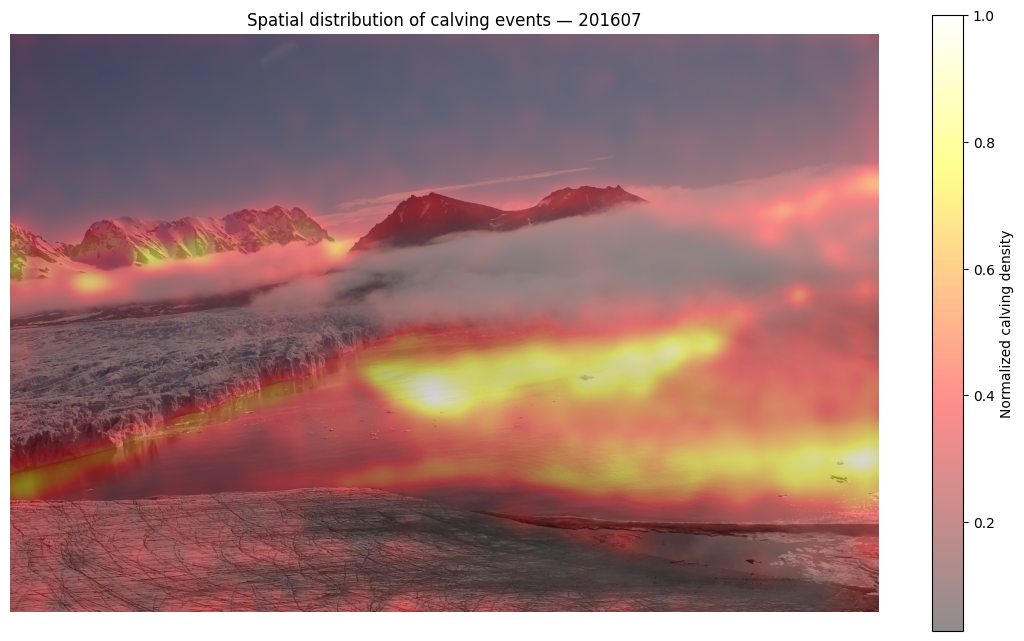

In [28]:
# =====================================================
# STAGE 6: Spatial Heatmap on a Reference Image
# =====================================================

import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

BASE_DIR = "/content/drive/MyDrive/DATASETS/Hansbreen_2016"
CSV_PATH = "/content/drive/MyDrive/DATASETS/calving_events.csv"

# -----------------------------------------------------
# Load events
# -----------------------------------------------------
df = pd.read_csv(CSV_PATH)

# IMPORTANT: month is INTEGER (YYYYMM)
REF_MONTH = 201607

# -----------------------------------------------------
# Load reference image (first image of the month)
# -----------------------------------------------------
ref_folder = os.path.join(BASE_DIR, str(REF_MONTH))
ref_file = sorted([f for f in os.listdir(ref_folder) if f.lower().endswith(".jpg")])[0]
ref_path = os.path.join(ref_folder, ref_file)

ref_img_bgr = cv2.imread(ref_path)
ref_img_rgb = cv2.cvtColor(ref_img_bgr, cv2.COLOR_BGR2RGB)

print("Reference image:", ref_file)
print("Reference image shape:", ref_img_rgb.shape)

# -----------------------------------------------------
# Filter events for reference month (FIXED)
# -----------------------------------------------------
df_m = df[df["month"] == REF_MONTH].copy()
print("Events in reference month:", len(df_m))

# -----------------------------------------------------
# Build spatial density heatmap
# -----------------------------------------------------
H, W, _ = ref_img_rgb.shape

heatmap = np.zeros((H, W), dtype=np.float32)

# Accumulate event centroids
for _, row in df_m.iterrows():
    x = int(row["centroid_x"])
    y = int(row["centroid_y"])
    if 0 <= x < W and 0 <= y < H:
        heatmap[y, x] += 1

# Smooth heatmap
heatmap = cv2.GaussianBlur(heatmap, (0, 0), sigmaX=40, sigmaY=40)

# Normalize
heatmap_norm = heatmap / heatmap.max()

# -----------------------------------------------------
# Overlay heatmap on reference image
# -----------------------------------------------------
plt.figure(figsize=(14, 8))
plt.imshow(ref_img_rgb)
plt.imshow(heatmap_norm, cmap="hot", alpha=0.45)
plt.colorbar(label="Normalized calving density")
plt.title(f"Spatial distribution of calving events — {REF_MONTH}")
plt.axis("off")
plt.show()


Build and display spatial heatmap overlay

Seasonal comparison heatmaps (spring vs summer)

Prepare seasonal subsets + reference image

In [31]:
# =====================================================
# STAGE 7A: Prepare seasonal subsets (Spring vs Summer)
# =====================================================

import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

BASE_DIR = "/content/drive/MyDrive/DATASETS/Hansbreen_2016"
CSV_PATH = "/content/drive/MyDrive/DATASETS/calving_events.csv"

# -----------------------------------------------------
# Load events
# -----------------------------------------------------
df = pd.read_csv(CSV_PATH)

# Month is integer: YYYYMM
SPRING_MONTHS = [201604, 201605]          # April–May
SUMMER_MONTHS = [201607, 201608]          # July–August

df_spring = df[df["month"].isin(SPRING_MONTHS)].copy()
df_summer = df[df["month"].isin(SUMMER_MONTHS)].copy()

print("Spring events:", len(df_spring))
print("Summer events:", len(df_summer))

# -----------------------------------------------------
# Load a reference image (use July as stable reference)
# -----------------------------------------------------
REF_MONTH = 201607
ref_folder = os.path.join(BASE_DIR, str(REF_MONTH))
ref_file = sorted([f for f in os.listdir(ref_folder) if f.lower().endswith(".jpg")])[0]
ref_path = os.path.join(ref_folder, ref_file)

ref_img_bgr = cv2.imread(ref_path)
ref_img_rgb = cv2.cvtColor(ref_img_bgr, cv2.COLOR_BGR2RGB)

H, W, _ = ref_img_rgb.shape

print("Reference image:", ref_file)
print("Reference shape:", ref_img_rgb.shape)


Spring events: 53167
Summer events: 331184
Reference image: 20160701_0733_IMG_3501.JPG
Reference shape: (2848, 4272, 3)


Build and compare seasonal heatmaps

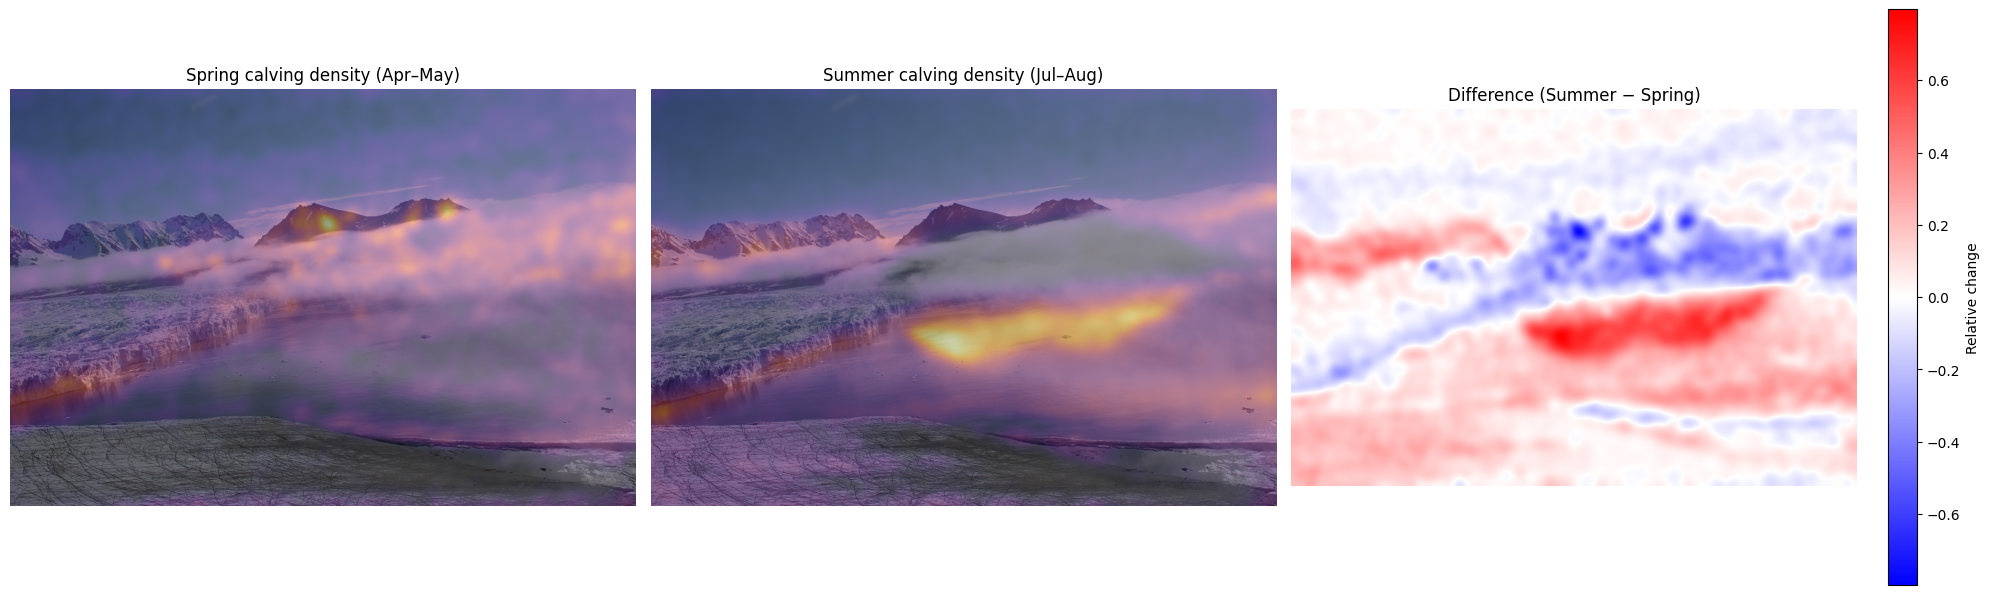

In [33]:
# =====================================================
# STAGE 7B: Seasonal comparison heatmaps
# =====================================================

def build_heatmap(df_events, height, width, sigma=40):
    """Build a smoothed and normalized spatial heatmap."""
    heat = np.zeros((height, width), dtype=np.float32)

    for _, row in df_events.iterrows():
        x = int(row["centroid_x"])
        y = int(row["centroid_y"])
        if 0 <= x < width and 0 <= y < height:
            heat[y, x] += 1

    heat = cv2.GaussianBlur(heat, (0, 0), sigmaX=sigma, sigmaY=sigma)
    return heat / heat.max()

# Build heatmaps
heat_spring = build_heatmap(df_spring, H, W)
heat_summer = build_heatmap(df_summer, H, W)

# -----------------------------------------------------
# Plot comparison
# -----------------------------------------------------
fig, axes = plt.subplots(1, 3, figsize=(20, 7))

# Spring
axes[0].imshow(ref_img_rgb)
axes[0].imshow(heat_spring, cmap="inferno", alpha=0.45)
axes[0].set_title("Spring calving density (Apr–May)")
axes[0].axis("off")

# Summer
axes[1].imshow(ref_img_rgb)
axes[1].imshow(heat_summer, cmap="inferno", alpha=0.45)
axes[1].set_title("Summer calving density (Jul–Aug)")
axes[1].axis("off")

# Difference (Summer − Spring)
diff = heat_summer - heat_spring
im = axes[2].imshow(diff, cmap="bwr", vmin=-diff.max(), vmax=diff.max())
axes[2].set_title("Difference (Summer − Spring)")
axes[2].axis("off")

plt.colorbar(im, ax=axes[2], fraction=0.046, label="Relative change")
plt.tight_layout()
plt.show()



Rule-based calving style inferenc



In [11]:
# =====================================================
# STAGE 8A: Rule-based calving style inference
# Environment: Google Colab
# =====================================================

import pandas as pd
import numpy as np

CSV_PATH = "/content/drive/MyDrive/DATASETS/calving_events.csv"
OUTPUT_CSV = "/content/drive/MyDrive/DATASETS/calving_events_with_style.csv"

# Load detected events
df = pd.read_csv(CSV_PATH)

# -----------------------------------------------------
# PARAMETERS (can be tuned)
# -----------------------------------------------------

# Approximate waterline position (fraction of image height)
# Assumption: waterline is around 60% of image height
WATERLINE_FRAC = 0.60

# Tolerance around waterline (pixels)
WATERLINE_TOL = 40

# Area thresholds (percentiles)
AREA_LARGE_P = np.percentile(df["event_area_px"], 90)
AREA_SMALL_P = np.percentile(df["event_area_px"], 30)

# -----------------------------------------------------
# Infer image height from centroid distribution
# (safe approximation if images are consistent)
# -----------------------------------------------------
IMAGE_HEIGHT = df["centroid_y"].max() * 1.05
WATERLINE_Y = IMAGE_HEIGHT * WATERLINE_FRAC

# -----------------------------------------------------
# Rule-based classification
# -----------------------------------------------------
def infer_style(row):
    area = row["event_area_px"]
    y = row["centroid_y"]

    # Sheet collapse: very large events
    if area >= AREA_LARGE_P:
        return "Sheet collapse"

    # Waterline: close to waterline
    if abs(y - WATERLINE_Y) <= WATERLINE_TOL:
        return "Waterline"

    # Submarine: below waterline and small
    if y > WATERLINE_Y and area <= AREA_SMALL_P:
        return "Submarine"

    # Icefall: above waterline, medium size
    if y < WATERLINE_Y:
        return "Icefall"

    # Fallback
    return "Unclassified"

df["calving_style"] = df.apply(infer_style, axis=1)

# -----------------------------------------------------
# Save results
# -----------------------------------------------------
df.to_csv(OUTPUT_CSV, index=False)

print("Saved classified events to:", OUTPUT_CSV)
print(df["calving_style"].value_counts())


Saved classified events to: /content/drive/MyDrive/DATASETS/calving_events_with_style.csv
calving_style
Icefall           285128
Unclassified      127643
Submarine          85322
Sheet collapse     58287
Waterline          26472
Name: count, dtype: int64


Prepare time series per calving style

In [12]:
# =====================================================
# STAGE 8B: Reproduce Figure 5 (a) — Style-based time series
# =====================================================

import pandas as pd

CSV_PATH = "/content/drive/MyDrive/DATASETS/calving_events_with_style.csv"

# Load data
df = pd.read_csv(CSV_PATH)
df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")
df = df.dropna(subset=["timestamp"])

# Create daily bins
df["date"] = df["timestamp"].dt.date

# Count events per day and style
daily_counts = (
    df.groupby(["date", "calving_style"])
      .size()
      .reset_index(name="count")
)

# Compute daily cumulative event size
daily_size = (
    df.groupby("date")["event_area_px"]
      .sum()
      .reset_index(name="cumulative_size")
)

print(daily_counts.head())
print(daily_size.head())


         date   calving_style  count
0  2016-04-14         Icefall    981
1  2016-04-14  Sheet collapse    128
2  2016-04-14       Submarine     86
3  2016-04-14    Unclassified    139
4  2016-04-14       Waterline     41
         date  cumulative_size
0  2016-04-14         13076751
1  2016-04-15         55935134
2  2016-04-16         39382106
3  2016-04-17         53877499
4  2016-04-18         24621949


Plot Figure 5(a)-like visualization

In [13]:
# =====================================================
# STAGE 8B: Plot style-based calving frequency + cumulative size
# =====================================================

import plotly.express as px
from plotly.subplots import make_subplots

# Merge size info
plot_df = daily_counts.merge(daily_size, on="date", how="left")

# Create subplot with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Plot each calving style
styles = plot_df["calving_style"].unique()

for style in styles:
    dff = plot_df[plot_df["calving_style"] == style]
    fig.add_scatter(
        x=dff["date"],
        y=dff["count"],
        mode="lines",
        name=style,
        secondary_y=False
    )

# Plot cumulative size
fig.add_scatter(
    x=daily_size["date"],
    y=daily_size["cumulative_size"],
    mode="lines",
    name="Cumulative size",
    line=dict(color="black", width=3),
    secondary_y=True
)

# Axis labels
fig.update_xaxes(title_text="Date (2016)")
fig.update_yaxes(title_text="Calving frequency (events/day)", secondary_y=False)
fig.update_yaxes(title_text="Cumulative event size (px)", secondary_y=True)

fig.update_layout(
    title="Calving frequency by style and cumulative event size (Hansbreen, 2016)",
    height=520,
    margin=dict(l=20, r=20, t=80, b=20),
    legend_title="Calving style"
)

fig.show()


Assign zones based on centroid_x

In [39]:
# =====================================================
# STAGE 8C: Assign terminus zones based on centroid_x
# =====================================================

import pandas as pd
import numpy as np

CSV_PATH = "/content/drive/MyDrive/DATASETS/calving_events_with_style.csv"
OUTPUT_CSV = "/content/drive/MyDrive/DATASETS/calving_events_with_style_and_zone.csv"

# Load data
df = pd.read_csv(CSV_PATH)

# Infer image width from centroid distribution
IMAGE_WIDTH = df["centroid_x"].max() * 1.05

# Define zone boundaries (fractions of width)
ZONE_EDGES = np.linspace(0, IMAGE_WIDTH, 6)
ZONE_LABELS = ["Zone I", "Zone II", "Zone III", "Zone IV", "Zone V"]

# Assign zones
df["zone"] = pd.cut(
    df["centroid_x"],
    bins=ZONE_EDGES,
    labels=ZONE_LABELS,
    include_lowest=True
)

# Save updated dataset
df.to_csv(OUTPUT_CSV, index=False)

print("Zone counts:")
print(df["zone"].value_counts())


Zone counts:
zone
Zone IV     132419
Zone III    128967
Zone I      109728
Zone II     107825
Zone V      103913
Name: count, dtype: int64


Plot zone-based pie charts (Figure 5b style)

In [42]:
# =====================================================
# STAGE 9C: Plot zone-based pie charts of calving styles
# =====================================================

import plotly.express as px
from plotly.subplots import make_subplots

# Reload with zones
df = pd.read_csv(OUTPUT_CSV)

zones = ["Zone I", "Zone II", "Zone III", "Zone IV", "Zone V"]

fig = make_subplots(
    rows=1, cols=5,
    specs=[[{"type": "domain"}]*5],
    subplot_titles=zones
)

for i, zone in enumerate(zones):
    dff = df[df["zone"] == zone]
    if dff.empty:
        continue

    counts = dff["calving_style"].value_counts().reset_index()
    counts.columns = ["calving_style", "count"]

    pie = px.pie(
        counts,
        names="calving_style",
        values="count",
        hole=0.0
    )

    for trace in pie.data:
        fig.add_trace(trace, row=1, col=i+1)

fig.update_layout(
    title="Distribution of calving styles across terminus zones (Hansbreen, 2016)",
    height=420,
    margin=dict(l=20, r=20, t=80, b=20),
    legend_title="Calving style"
)

fig.show()


In [41]:
# ============================================
# STAGE 9A: Rule-based Calving Style Inference
# ============================================

import numpy as np

# --- Define waterline (pixel y-coordinate)
WATERLINE_Y = 1700

# --- Area thresholds (pixels) - empirical & paper-aligned
SMALL_AREA = 2_000
LARGE_AREA = 100_000

def infer_calving_style(row):
    y = row["centroid_y"]
    area = row["event_area_px"]

    # Sheet collapse: very large events
    if area >= LARGE_AREA:
        return "Sheet collapse"

    # Submarine calving: below waterline
    if y > WATERLINE_Y:
        return "Submarine"

    # Waterline calving: near waterline
    if abs(y - WATERLINE_Y) < 150:
        return "Waterline"

    # Icefall: small events above waterline
    if area <= SMALL_AREA:
        return "Icefall"

    # Default fallback
    return "Waterline"


# Apply rule-based classification
df["calving_style"] = df.apply(infer_calving_style, axis=1)

# Quick sanity check
df["calving_style"].value_counts()


,count
calving_style,
Submarine,267633
Waterline,163528
Icefall,136129
Sheet collapse,15562


In [37]:
import numpy
import pandas
import cv2
import plotly
import dash
import jupyter_dash

print("numpy:", numpy.__version__)
print("pandas:", pandas.__version__)
print("opencv-python:", cv2.__version__)
print("plotly:", plotly.__version__)
print("dash:", dash.__version__)
print("jupyter-dash:", jupyter_dash.__version__)


numpy: 2.0.2
pandas: 2.2.2
opencv-python: 4.12.0
plotly: 5.24.1
dash: 2.17.1
jupyter-dash: 0.4.2
